<H1><center>Predict future sales</center></H1>

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.



### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Suppress warnings
warnings.filterwarnings("ignore")

### Loading data

In [2]:
test = pd.read_csv('../input/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../input/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

### Join data sets

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Let's take a look at the raw data

In [4]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [5]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Time period

In [7]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Data preprocessing
We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [8]:
# Select only usefeul features (here I won't be using the text features).
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
# # Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum'], 'item_cnt_day':['sum','count']})
# # Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt', 'transactions']

### New dataset

In [9]:
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_category_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5573.00,5575.00,5576.00,5609.00,5612.00,5623.00,5627.00,5629.00,5630.00
item_price,7932.00,560.00,2418.00,11155.00,2381.00,3623.00,294.00,4120.00,15400.00,2060.00
item_cnt,10.00,1.00,4.00,5.00,1.00,1.00,1.00,2.00,9.00,1.00
transactions,6.00,1.00,3.00,5.00,1.00,1.00,1.00,2.00,8.00,1.00


In [10]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### EDA

In [11]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### How sales behaves along the year?

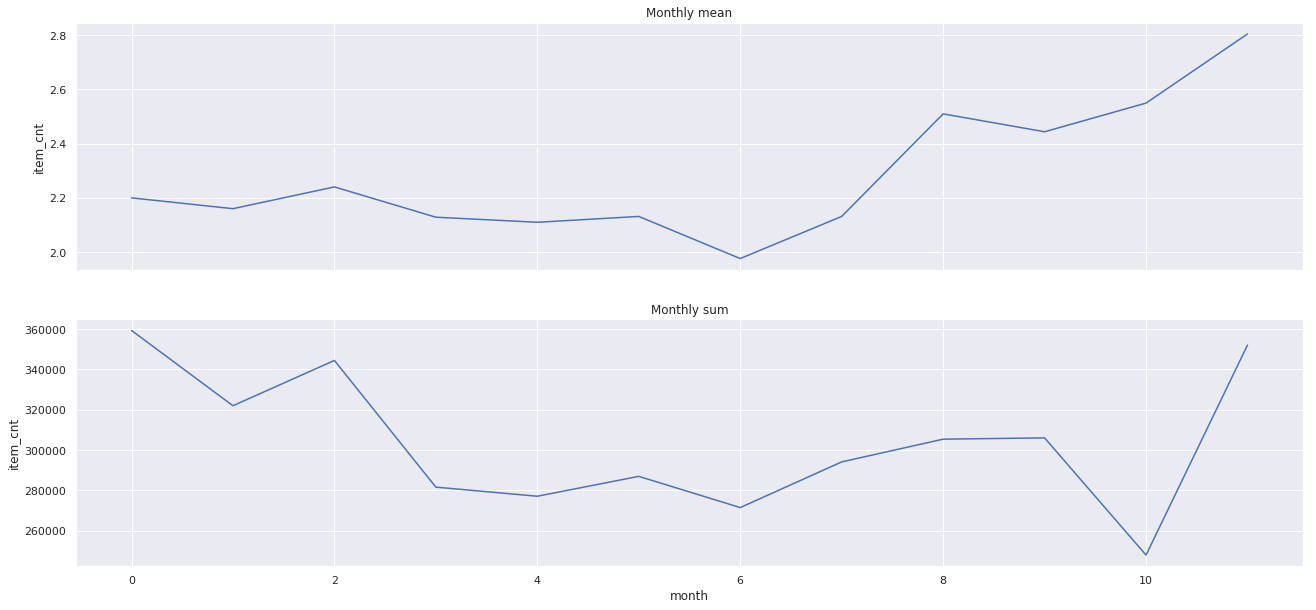

In [12]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### What category sells more?

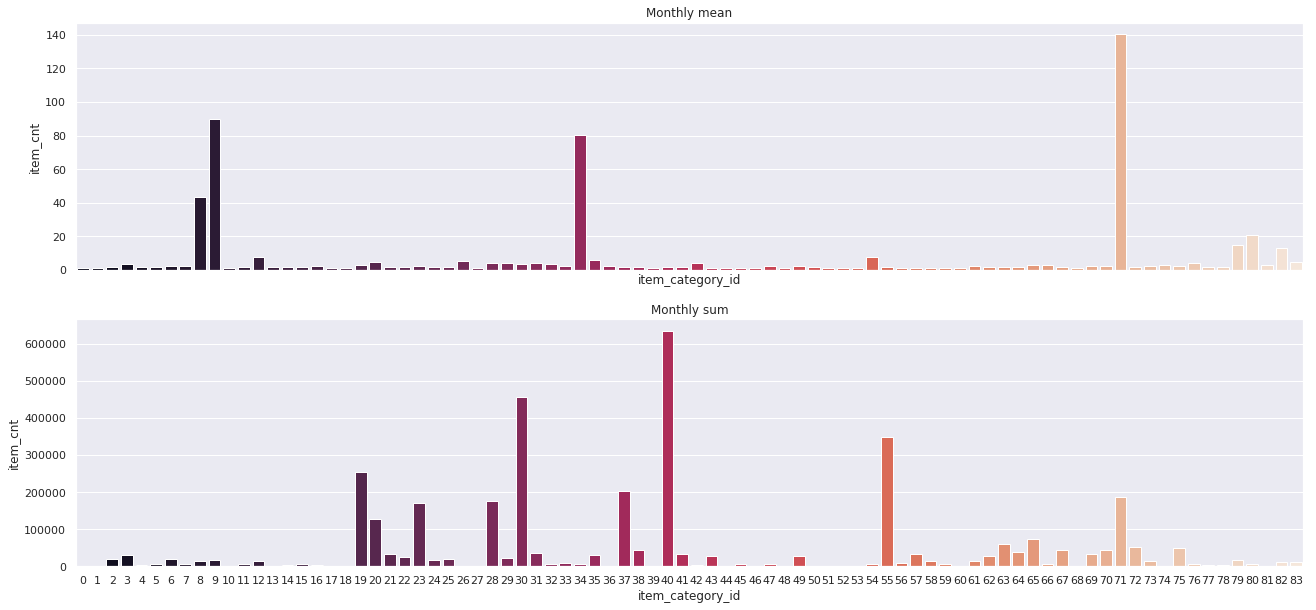

In [13]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### What shop sells more?

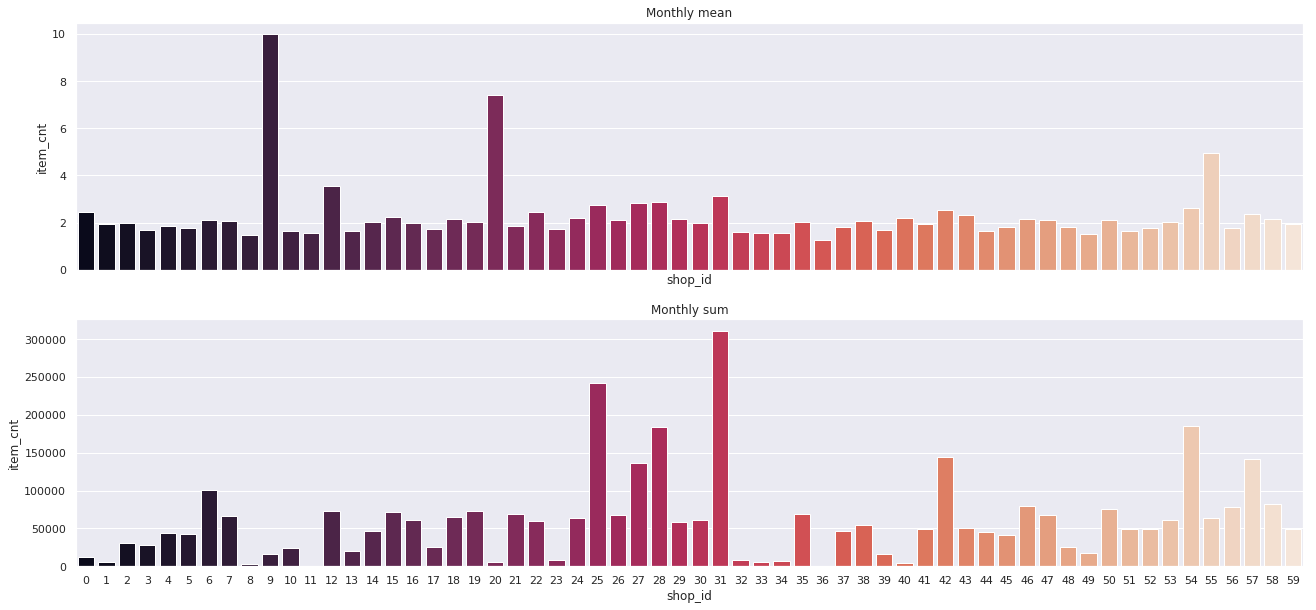

In [14]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### Checking for outliers

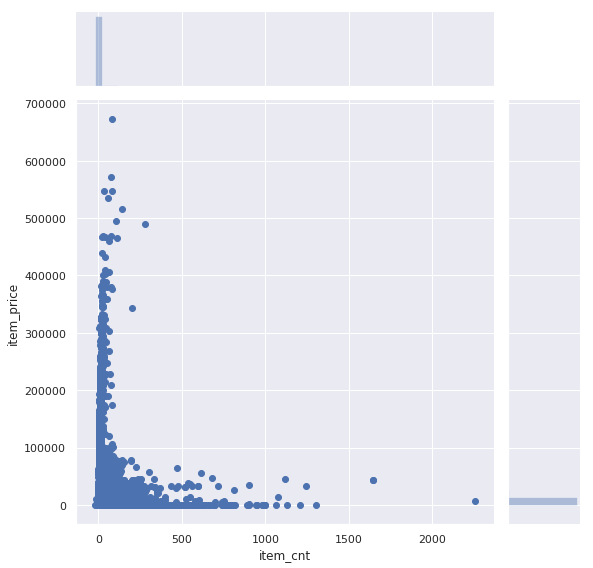

In [15]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

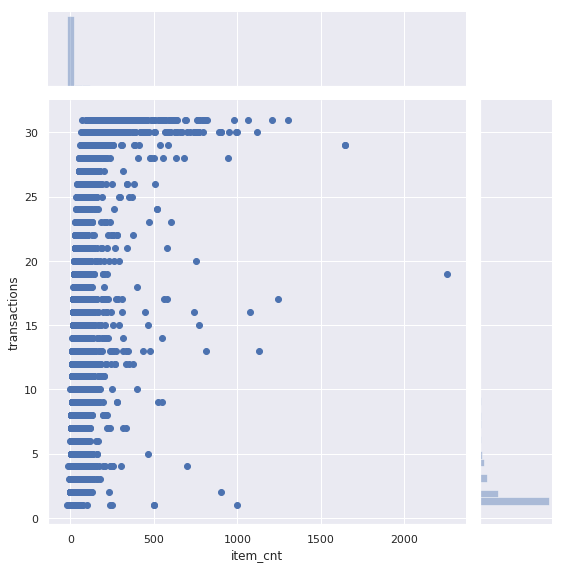

In [16]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

### "item_cnt" distribution.

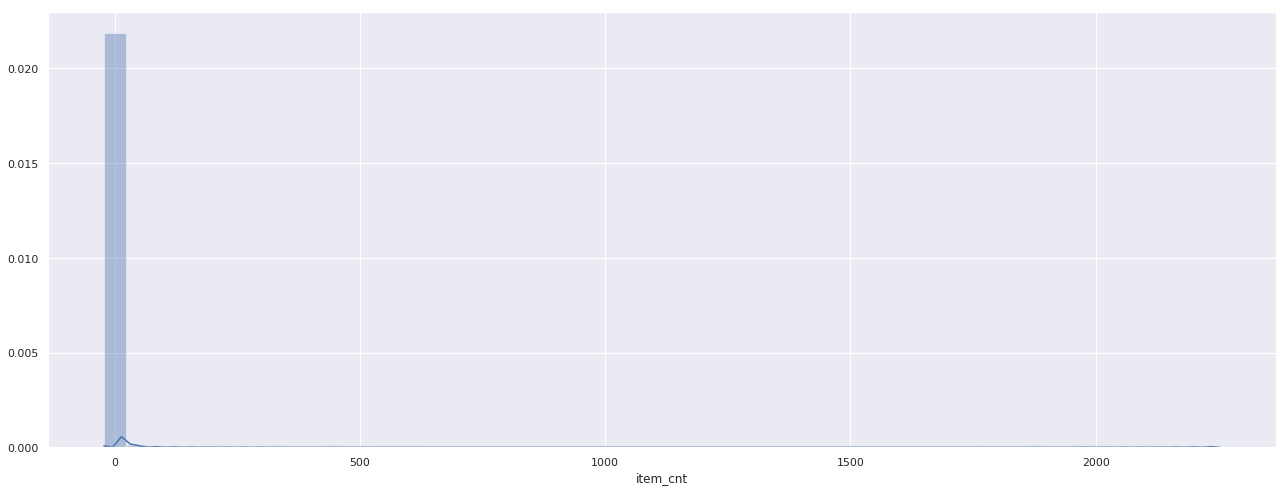

In [17]:
plt.subplots(figsize=(22, 8))
sns.distplot(train_monthly['item_cnt'])
plt.show()

#### Removing outliers
I'll treat "item_cnt" > 20, "item_price" >= 500000 and "transactions" >= 35 as outliers, so I'll remove them.

In [18]:
train_monthly = train_monthly.query('item_cnt <= 20 and item_price < 500000 and transactions < 35')

### Creating the label
Our label will be the "item_cnt" of the next month

In [19]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

### Feature engineering

In [20]:
# Get the unitary item prices
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']

In [21]:
# Group based features.
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [22]:
# How much each item's price changed from its (low/high) historical price.
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [23]:
# Rolling window based features [window = 12 months].
# Min values
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Median value
f_median = lambda x: x.rolling(window=3, min_periods=1).median()
# Stardad deviation value
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

# function_list = [f_min, f_max, f_mean, f_median, f_std]
# function_name = ['min', 'max', 'mean', 'median', 'std']
function_list = [f_mean, f_median, f_std]
function_name = ['mean', 'median', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [24]:
# Lag based features.
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

### Dataset after feature engineering

In [25]:
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_category_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5573.00,5575.00,5576.00,5609.00,5612.00,5623.00,5627.00,5629.00,5630.00
item_price,7932.00,560.00,2418.00,11155.00,2381.00,3623.00,294.00,4120.00,15400.00,2060.00
item_cnt,10.00,1.00,4.00,5.00,1.00,1.00,1.00,2.00,9.00,1.00
transactions,6.00,1.00,3.00,5.00,1.00,1.00,1.00,2.00,8.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00
month,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_cnt_month,11.00,1.00,nan,2.00,1.00,nan,3.00,4.00,5.00,1.00


### Data leakages

About data leakages the only thing that I'll be doing here is to use only the "shop_id" and "item_id" that appear on the test set.

In [26]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
lk_train = train_monthly[train_monthly['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [27]:
print('Data set size before leaking:', train_monthly.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 1597661
Data set size after leaking: 594081


### Train/validation split
* As we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
* Our train set will be the first 4~28 blocks, validation will be last 5 blocks and test will be block 33.

In [28]:
train_set = lk_train.query('date_block_num >= 4 and date_block_num < 30').copy()
validation_set = lk_train.query('date_block_num >= 30 and date_block_num < 33').copy()
test_set = lk_train.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

Train set records: 403911
Validation set records: 45727
Test set records: 28495


In [29]:
print('Train set records: %s (%.f%% of data)' % (train_set.shape[0], ((train_set.shape[0]/lk_train.shape[0])*100)))
print('Validation set records: %s (%.f%% of data)' % (validation_set.shape[0], ((validation_set.shape[0]/lk_train.shape[0])*100)))

Train set records: 403911 (68% of data)
Validation set records: 45727 (8% of data)


### Mean encoding

In [30]:
# Mean encoding (done after the data split).
gp_shop_mean = train_set.groupby(['shop_id'])['item_cnt'].mean()
gp_item_mean = train_set.groupby(['item_id'])['item_cnt'].mean()

train_set['shop_mean'] = train_set['shop_id'].map(gp_shop_mean)
validation_set['shop_mean'] = validation_set['shop_id'].map(gp_shop_mean)
test_set['shop_mean'] = test_set['shop_id'].map(gp_shop_mean)

train_set['item_mean'] = train_set['item_id'].map(gp_item_mean)
validation_set['item_mean'] = validation_set['item_id'].map(gp_item_mean)
test_set['item_mean'] = test_set['item_id'].map(gp_item_mean)

In [31]:
# Train and validation sets/labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [32]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### Build test set
We want to predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. In other words we use block 33 because we want to forecast values for block 34.

In [33]:
X_test = pd.merge(test, pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last'), on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [34]:
# Replace missing values with the median of each shop.
sets = [X_train, X_validation, X_test]

for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median

# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [35]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

### Modeling the data
* Data normalization  won't be done here since I'm using a tree based model.

### Catboost

In [36]:
cat_features = [0, 1, 5, 6]

catboost_model = CatBoostRegressor(
    iterations=500,
    random_seed=0,
    od_type='Iter',
    od_wait=20,
    verbose=50,
    depth=8
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

0:	learn: 2.9427515	test: 2.8209780	best: 2.8209780 (0)	total: 405ms	remaining: 3m 21s
50:	learn: 1.6855700	test: 1.6998909	best: 1.6998909 (50)	total: 14.5s	remaining: 2m 7s
100:	learn: 1.5285939	test: 1.6323749	best: 1.6323749 (100)	total: 27.7s	remaining: 1m 49s
150:	learn: 1.4952963	test: 1.6246896	best: 1.6246896 (150)	total: 43s	remaining: 1m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.623944809
bestIteration = 155

Shrink model to first 156 iterations.


In [37]:
print('Model is fitted: ' + str(catboost_model.is_fitted()))
print('Model params:', catboost_model.get_params())

Model is fitted: True
Model params: {'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 20, 'loss_function': 'RMSE', 'depth': 8, 'iterations': 500}


In [38]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

### Let's see how catboost performed with this "prediction x label" plot.
The closer the points are to the middle dashed line the better are the predictions.

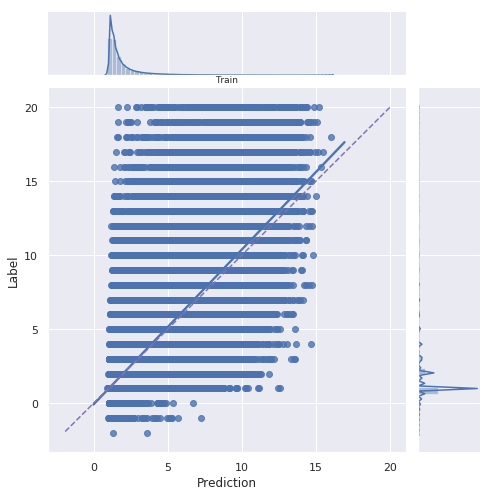

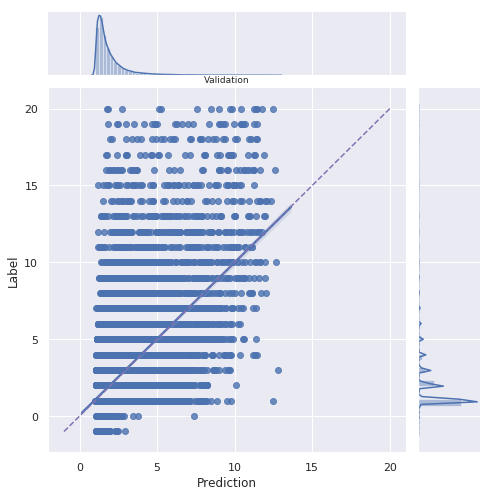

In [39]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

### Random forest

In [40]:
# Use only part of feature on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'month', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [41]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [42]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [43]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 1.5796143609849738
Validation rmse: 1.6371376441260588


### Let's see how random forest performed with this "prediction x label" plot.

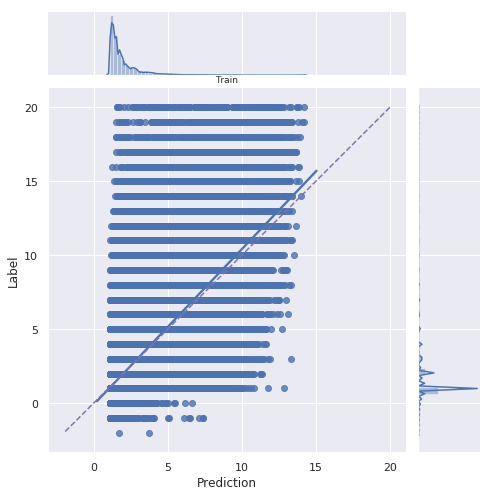

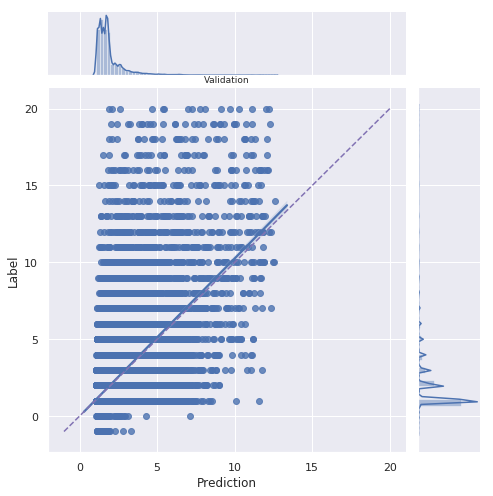

In [44]:
model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

### KNN Regressor

In [45]:
# Use only part of feature on KNN.
knn_features = ['shop_id', 'item_id', 'item_cnt', 'year', 'month', 'item_cnt_mean',
                   'item_cnt_std', 'item_cnt_shifted1', 'item_cnt_shifted2',
                   'item_cnt_shifted3', 'shop_mean', 'item_mean']
knn_train = X_train[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [46]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')

In [47]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [48]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 1.4576378195838333
Validation rmse: 1.7484515249143873


### Let's see how knn performed with this "prediction x label" plot.

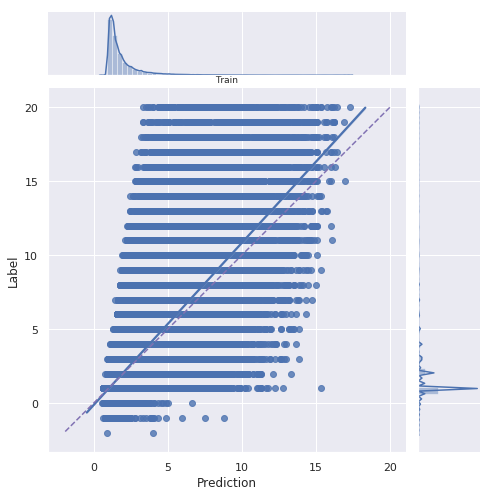

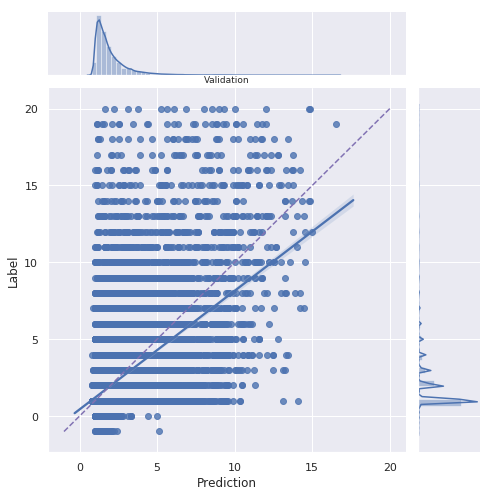

In [49]:
model_performance_sc_plot(knn_train_pred, Y_train, 'Train')
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

### Linear Regression

In [50]:
lr_features = ['shop_id', 'item_id', 'item_cnt', 'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [51]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [52]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [53]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 1.719212509280309
Validation rmse: 1.6406383099517508


### Let's see how linear regression performed with this "prediction x label" plot.

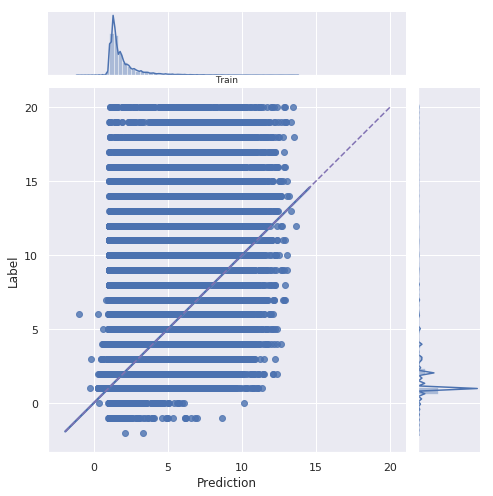

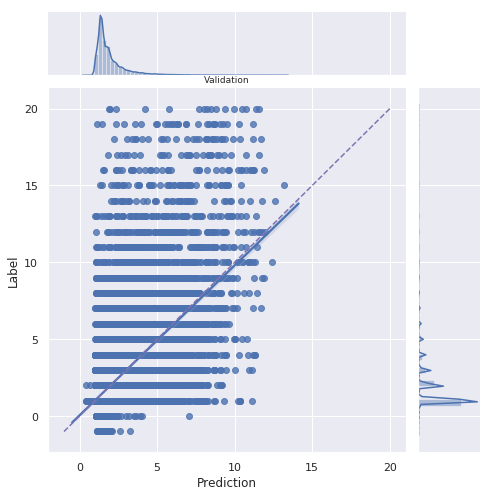

In [54]:
model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

### XGBoosting

In [55]:
xgb_train = X_train
xgb_val = X_validation
xgb_test = X_test

In [56]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=0)

xgb_model.fit(
    xgb_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
    verbose=20, 
    early_stopping_rounds=20)

[0]	validation_0-rmse:2.52009	validation_1-rmse:2.39021
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:1.57422	validation_1-rmse:1.63979
[40]	validation_0-rmse:1.51082	validation_1-rmse:1.61196
[60]	validation_0-rmse:1.48938	validation_1-rmse:1.61404
Stopping. Best iteration:
[43]	validation_0-rmse:1.50714	validation_1-rmse:1.61103



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=0.8)

In [57]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [58]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 1.5071379214949807
Validation rmse: 1.6110309031198684


### Let's see how XGBoosting performed with this "prediction x label" plot.

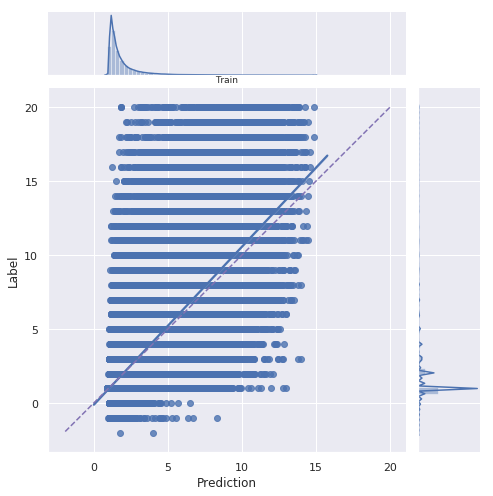

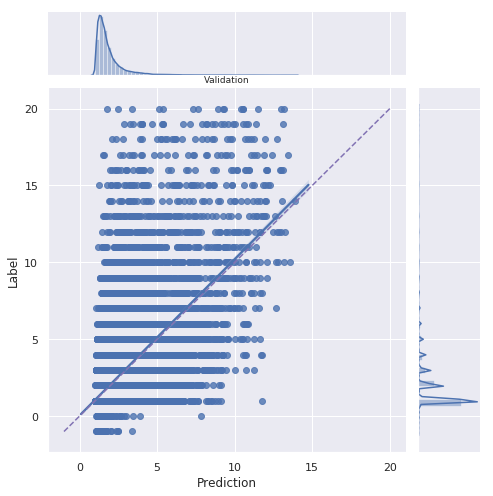

In [59]:
model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')

### Create new datasets with the predictions from first level models

In [60]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['random_forest'] = rf_val_pred
first_level['knn'] = knn_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['xgbm'] = xgb_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,random_forest,knn,linear_regression,xgbm,label
0,1.67,1.78,1.33,1.81,1.75,1
1,1.66,1.51,1.44,1.43,1.49,1
2,1.29,1.36,1.33,1.32,1.26,1
3,1.65,1.75,1.89,1.74,1.68,1
4,1.67,1.51,1.33,1.45,1.59,1
5,1.84,1.72,2.33,1.32,1.78,3
6,2.58,1.85,2.00,2.23,2.20,1
7,1.79,1.83,1.89,1.08,1.98,1
8,1.30,1.36,1.00,1.81,1.42,2
9,1.76,1.75,2.11,1.73,1.63,1


In [61]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['xgbm'] = xgb_test_pred
first_level_test.head()

,catboost,random_forest,knn,linear_regression,xgbm
0,1.85,1.81,2.00,2.17,1.73
1,1.12,1.29,2.56,1.26,1.25
2,1.78,1.91,2.00,2.37,1.75
3,1.12,1.29,2.00,1.26,1.25
4,1.12,1.29,1.22,1.26,1.25


### Ensembling

To combine the other models (1st level) predictions, I'll use a simple linear regression.

#### Stacking architecture:
* 1st level:
    * Catboost
    * Random forest
    * KNN
    * Linear Regression
    * XGBM
* 2nd level;
    * Linear Regression

In [62]:
meta_model = LinearRegression(n_jobs=-1)
# Drop label from data set.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [63]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 1.5835695871217281


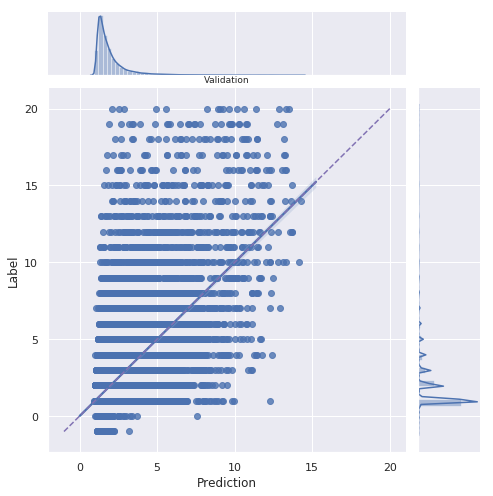

In [64]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

In [ ]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)